In [15]:
lst = 'anton, andereas, perter'.split(', ')

for i in lst:
    print(i)

anton
andereas
perter
anton
andereas
perter


[None, None, None]

In [70]:
# First up lets make the datasets\
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import plotly.graph_objects as go


def make_spiral(size, dim=3, a=1, b=0.15, plot=False):
    rand_angle = np.random.rand(size)*15
    r = a*np.exp(b*rand_angle)
    x,y = np.cos(rand_angle)/r , np.sin(rand_angle)/r
    z = np.random.rand(len(x))
    if dim == 2:
        return np.vstack((x,y)).T
    elif dim ==3:
        return np.vstack((x,y,z)).T

def make_planes(size = 1000, plot=False):
    x, y, z = np.random.rand(size), np.random.rand(size), np.zeros(size)
    z[:size//2], z[size//2:] = 2*x[:size//2]+1, -2*x[size//2:]-1
    return np.vstack((x,y,z)).T

def plot_3d_scatter(data):
    x,y,z = data[:,0],data[:,1],data[:,2]
    fig = go.Figure(
        data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
        marker=dict(size=4, color=z, colorscale='Viridis', opacity=0.8)), ])
    fig.show()

<function make_spiral at 0x11b3054c0>
<function make_spiral at 0x11b3054c0>
<function make_planes at 0x11b305700>


<ipython-input-202-9ea7e9aaf84b>:64: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



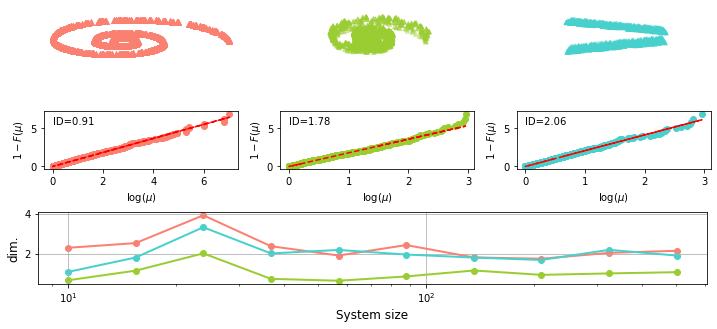

In [202]:

fig = plt.figure(figsize=plt.figaspect(.4))
colors = 'salmon, yellowgreen, mediumturquoise, orange, black, red'.split(', ')

elev, azim = [0,70,10], [0,270,90]

size = 1000

for index, func in enumerate([make_spiral, make_spiral,make_planes]):
    print(func)
    
    if index == 0:
        data = func(size, dim=2)
        ax = fig.add_subplot(3,3,index+1)
        xs, ys = data[:,0], data[:,1]
        ax.scatter(xs, ys, c= colors[index], marker=m)
        ax.set_ylim(1.8*min(ys), 1.6*max(ys))
        ax.set_axis_off()
        
        x,y,d = nn2(data, plot=False, return_xy=True)
        ax = fig.add_subplot(3,3,index+1+3)
        plt.scatter(x,y, c=colors[index])
        plt.plot(x,x*d, c='r', ls='--')
        plt.text(min(x), max(y)*.8, 'ID={}'.format(round(d,2)))
        ax.set_xlabel('$\log{(\mu)}$')
        ax.set_ylabel('$1-F(\mu)$')
        
    
    else:
        data = func(size)
        ax = fig.add_subplot(3,3,index+1, projection='3d')
        xs, ys, zs = data[:,0], data[:,1], data[:,2]
        ax.scatter(xs, ys, zs, marker=m, c=colors[index])
    
    
        ax.view_init(elev[index], azim[index])
        # make the panes transparent
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        # make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
        x,y,d = nn2(data, plot=False, return_xy=True)
        ax.set_axis_off()
        ax = fig.add_subplot(3,3,index+1+3)
        plt.scatter(x,y, c=colors[index])
        plt.plot(x,x*d, c='r', ls='--')
        plt.text(min(x), max(y)*.8, 'ID={}'.format(round(d,2)))
        ax.set_xlabel('$\log{(\mu)}$')
        ax.set_ylabel('$1-F(\mu)$')
#plt.show()
ax = fig.add_axes([0.05, 0., .93, 0.25])
for index, model in enumerate('spiral, spiral_2d, planes'.split(', ')):
    ds, sizes = time_and_performance(model)
    ax.plot(sizes,ds, c=colors[index], lw=2)
    ax.scatter(sizes,ds, c=colors[index])
ax.set_xscale('log')
ax.set_ylabel('dim.', fontsize=12)
ax.set_xlabel('System size', fontsize=12)
ax.grid()


plt.tight_layout()
plt.savefig('figures/2nn_synth.png', dpi=500, bbox_inches='tight')

In [104]:
# Now lets make the 2NN algorithm

In [106]:
def nn2(
    data,
    plot=True,
    return_xy = False):
    '''
    Find intrinsic dimension (ID) via 2-nearest-neighbours

    https://www.nature.com/articles/s41598-017-11873-y
    https://arxiv.org/pdf/2006.12953.pdf
    _______________
    Parameters:
        eigvecs
        plot : create a plot; boolean; dafault=False
    _______________
    Returns:
        m : Slope
    
    '''

    N = len(data)
    
    distance_matrix = np.zeros((N, N))
    # Making the distance matrix: distance from each eigvec to all others
    for i, eigvec1 in enumerate(data):
        for j, eigvec2 in enumerate(data):
            if j <= i:
                pass
            else:
                distance = sum(abs((eigvec1-eigvec2)))
                distance_matrix[i,j], distance_matrix[j,i] = distance, distance
        #print(distance_matrix) # To see how it fills √

    # table of distances - state and \mu= r_2/r_1
    mu = np.zeros((N,2))
    for index, line in enumerate(distance_matrix):
        r1, r2 = sorted(line)[1:3]
        mu[index,0] = index+1
        mu[index,1] = r2/r1
        
    #print(mu)

    #permutation function
    sigma_i = dict(zip(range(1,len(mu)+1), np.array(sorted(mu, key=lambda x: x[1]))[:,0].astype(int)))
    mu = dict(mu)
    #cdf F(mu_{sigma(i)})
    F_i = {}
    for i in mu:
        F_i[sigma_i[i]] = i/N

    #fitting coordinates
    x = np.log([mu[i] for i in sorted(mu.keys())])
    y = np.array([1-F_i[i] for i in sorted(mu.keys())])

    #avoid having log(0)
    x = x[y>0]
    y = y[y>0]

    y = -1*np.log(y)

    #fit line through origin to get the dimension
    d = np.linalg.lstsq(np.vstack([x, np.zeros(len(x))]).T, y, rcond=None)[0][0]

    if plot==True:
        #fig, ax = plt.subplots(2,1, sharex=True)
        plt.scatter(x,y, c='g')
        plt.plot(x,x*d, c='r', ls='--')
        plt.xlabel('log($\mu$)', fontsize=12)
        plt.ylabel('$1-F_i(\mu)$', fontsize=12)
        plt.text(0,4,round(d,3), fontsize=13)
    if return_xy:
        return x,y, d
    else:
        return d

2.1312373962667093

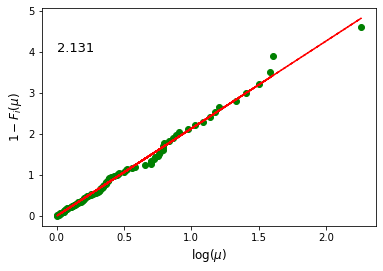

In [107]:
nn2(make_spiral(100))

In [182]:
def time_and_performance(
    method='spiral',
    size_max = 2.7, 
    steps = 10):
    
    sizes = np.logspace(1,size_max, steps)
    ds = []
    for size in sizes:
        size = int(size)
        #print(size)
        if method == 'spiral':
            data = generate_spiral(size)
        elif method == 'spiral_2d':
            data = generate_spiral_2d(size)
        elif method == 'planes':
            data = generate_planes(size)
        d = nn2(data, plot=False)
        ds.append(d)
    return ds, sizes
    

    #fig.suptitle('2NN Benchmark on {}'.format(method))
    
    

([5.175272922975028,
  3.5886097955789413,
  2.575177360127183,
  2.0298604828690263,
  2.6900992462215747,
  2.0334067311481068,
  2.3661505695250042,
  1.696023501534762,
  2.3058344639289534,
  2.155488655917589],
 array([ 10.        ,  15.44859148,  23.86589787,  36.86945065,
         56.95810811,  87.99225436, 135.93563909, 210.00141557,
        324.42260792, 501.18723363]))

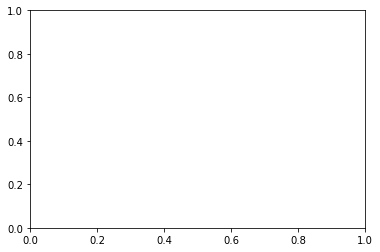

In [181]:
fig, ax = plt.subplots()
time_and_performance()